In [2]:
import pandas as pd
import numpy as np
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import pickle
import xgboost as xgb

%matplotlib inline
sns.set(style='ticks')
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

data = pd.read_csv("../input/creditcardfraud/creditcard.csv")

## Explore data

data.info()
data.tail()

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


* 30 feature columns in dataset. 
    - We don't know what V1-V26 are, but we know they have been scaled (boxplots show a similar range of values, to confirm).
    - Additionally,  'Time' in seconds, over a period of 2 days, is available. 
    - Majority of transactions are of a smaller 'Amount', mean is USD 88, range is ~ USD 0 - USD 25,691 range.
    
    
* No null values in dataset. 


* Imbalanced classes can be seen below. 

In [14]:
# Target contains imbalanced classes
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

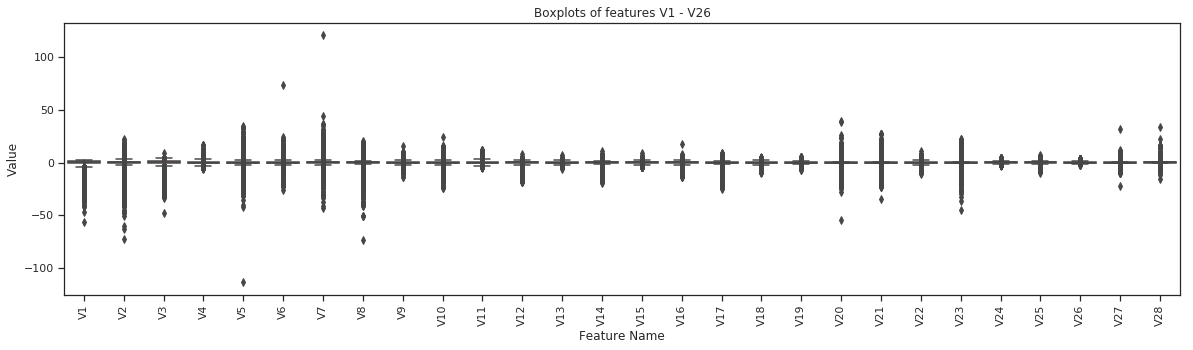

Text(0.5, 1.0, 'Boxplot of Amount feature')

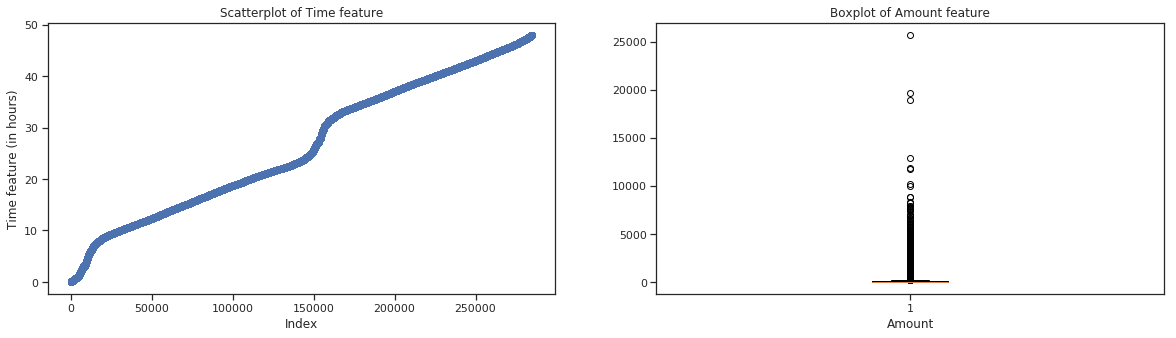

In [3]:
# Boxplot of variables V1 - V28
plt.figure(figsize=(20,5))
sns.boxplot(data=data.drop(['Time', 'Amount', 'Class'], axis=1))
plt.xticks(rotation=90)
plt.title('Boxplots of features V1 - V26')
plt.xlabel('Feature Name')
plt.ylabel('Value')
plt.show()

#datelist=pd.date_range("00:00:00", "23:59:59", freq="S")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(data.index, data['Time']/(60*60))
ax1.set_xlabel('Index')
ax1.set_ylabel('Time feature (in hours)')
ax1.set_title('Scatterplot of Time feature')
ax2.boxplot(data['Amount'])
ax2.set_xlabel('Amount')
ax2.set_title('Boxplot of Amount feature')

### Baseline model using XGBClassifier, using common test_train_split

In [4]:
X_train, X_test, y_train, y_test= train_test_split(data.drop('Class', axis=1), data.Class, 
                                                   test_size=0.5, random_state=123)

clf = xgb.XGBClassifier(n_estimators=50, seed=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: %f" % (accuracy))
print('As 99.828% of the data is class 0, the 99.927% heavily biased accuracy does not tell us much about the quality of our model .')

f1 = f1_score(y_test, y_pred)
print("f1 score is a better metric: %f" % (f1))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy: 0.999361
As 99.828% of the data is class 0, the 99.927% heavily biased accuracy does not tell us much about the quality of our model .
f1 score is a better metric: 0.818363
[[142108     39]
 [    52    205]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142147
           1       0.84      0.80      0.82       257

    accuracy                           1.00    142404
   macro avg       0.92      0.90      0.91    142404
weighted avg       1.00      1.00      1.00    142404



### Using hyperopt for XGBoostClassifier hyperparameter tuning 

* Parameter spaces can be built from manually entering values or selecting from one of these distrbutions.
    - hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
    - hp.randint(label, upper) — Returns a random integer between the range (0, upper).
    - hp.uniform(label, low, high) — Returns a value uniformly between low and high.
    - hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer
    - hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.
    
    
* The function optimized by hyperopt always minimizes - so we have to return 1-f1_score, in order to maximize this metric of our choice. 


* An odd feature: parameter names have to be provided twice in the parameter selection space. 


* XGBoost uses a special matrix type called a DMatrix. xgb.XGBClassifier automatically groups the data in a DMatrix, but when using cross validation or more complicated code, we must explicitly convert data to a DMatrix first. 


* the Trials() function stores data as the hyperopt algorithm progresses. It allows us to learn a few details about the internal working of the hyperopt algorithm. Running the Trials() function is optional. 



In [ ]:
# Below code has been commented out because it takes time a long time (~30 mins with. 8 cores, GPU acceleration) 
# to run on every commit. So it was run once and commented out.
"""
# defining the space for hyperparameter tuning
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       }

def hyperparameter_tuning(space):
    clf=xgb.XGBClassifier(max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],eta= 0.8, nthread=-1, 
                          n_estimators=50, random_state=123)
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    y_pred = clf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    # We want to ensure that every fraud case is reported. 
    # Even if we tradeoff a large number of false positives. 
    # So we will maximize recall (ie. minimize 1-recall)
    print ("Recall:", recall)
    return {'loss': 1-recall, 'status': STATUS_OK }


# run the hyper paramter tuning
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

print (best)
"""

In [ ]:
# Best output from hyperparameter tuning.
"""
              precision    recall  f1-score   support                              

           0       1.00      1.00      1.00    142147
           1       0.90      0.80      0.85       257

    accuracy                           1.00    142404
   macro avg       0.95      0.90      0.92    142404
weighted avg       1.00      1.00      1.00    142404

Recall:                                                                            
0.8015564202334631                                                                 
"""

In [ ]:
# Model with best parameters (80% recall, 85% f1 score)
clf = xgb.XGBClassifier(colsample_bytree= 0.7356225471858802,
 gamma = 5.0244632204209765,
 max_depth=15,
 min_child_weight=4,
 reg_alpha = 1,
 reg_lambda = 0.49906388627478493, eta= 0.8, nthread=-1, n_estimators=50, seed=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Default parameters in Vanilla baseline model (80% similar recall, 82% lower f1 score)
"""
colsample_bytree= 1,
 gamma = 0,
 max_depth = 6,
 min_child_weight = 1,
 reg_alpha = 0,
 reg_lambda = 1
"""

* Even though the baseline XGBoostClassifier has a similar recall and few percent lower f1 score, the tuned model is much better because: 
    - it has alpha & lambda regularization as well as a higher gamma value (higher gamma = greater gain threshold for maintaining nodes, and thus, more pruning). 
    - 7.36/10th fraction of the features are subsampled in the tuned model. We thus make the model run faster (and introduce regularization) without losing out on performance. 
    - The tuned model builds deeper trees (max depth 6 vs 15). A greater number of interactions can be captured by the tuned model. 
    - A higher weight threshold is used to allow/deny subdivision of node, in the tuned model. 
    
    
* Further tuning with a lower learning rate (eta) can be done to narrow down on a better model. 

* Finally. the precision-recall threshold should be changed to ensure better recall, if possible. We see in the current precision - recall curve, there is a sharp drop in precision if we require >80% recall. But we also see that the mean amount of 492 fraud transactions is higher than the mean of 284315 non-fraud transactions. Considering the higher losses, the bank may want to increase recall to ~99% even if it means more calls to customers to check on legitimate transctions flagged as fraud.       

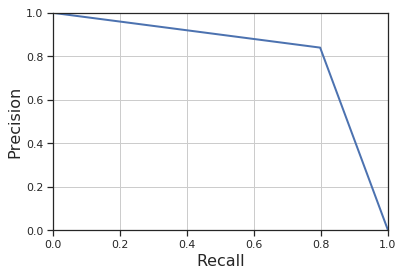

In [5]:
# Plot precision recall curve for current best model. 
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Mean Amounts for non-fraud (label 0) and fraud (label 1) transactions')

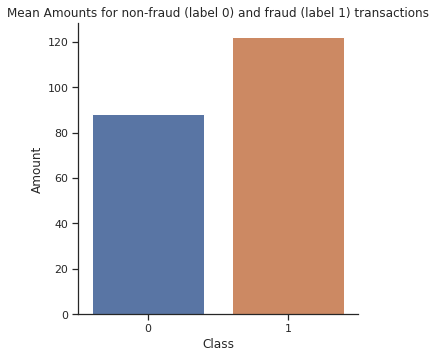

In [13]:
# Plot mean Amounts of non-fraud (label 0) and fraud (label 1) transactions
sns.catplot(x='Class', y='Amount', data=data, kind='bar', ci=None)
plt.title('Mean Amounts for non-fraud (label 0) and fraud (label 1) transactions' )